In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

from keras_transfer_learning.utils import visualize
visualize.set_default_plotting()

Using TensorFlow backend.


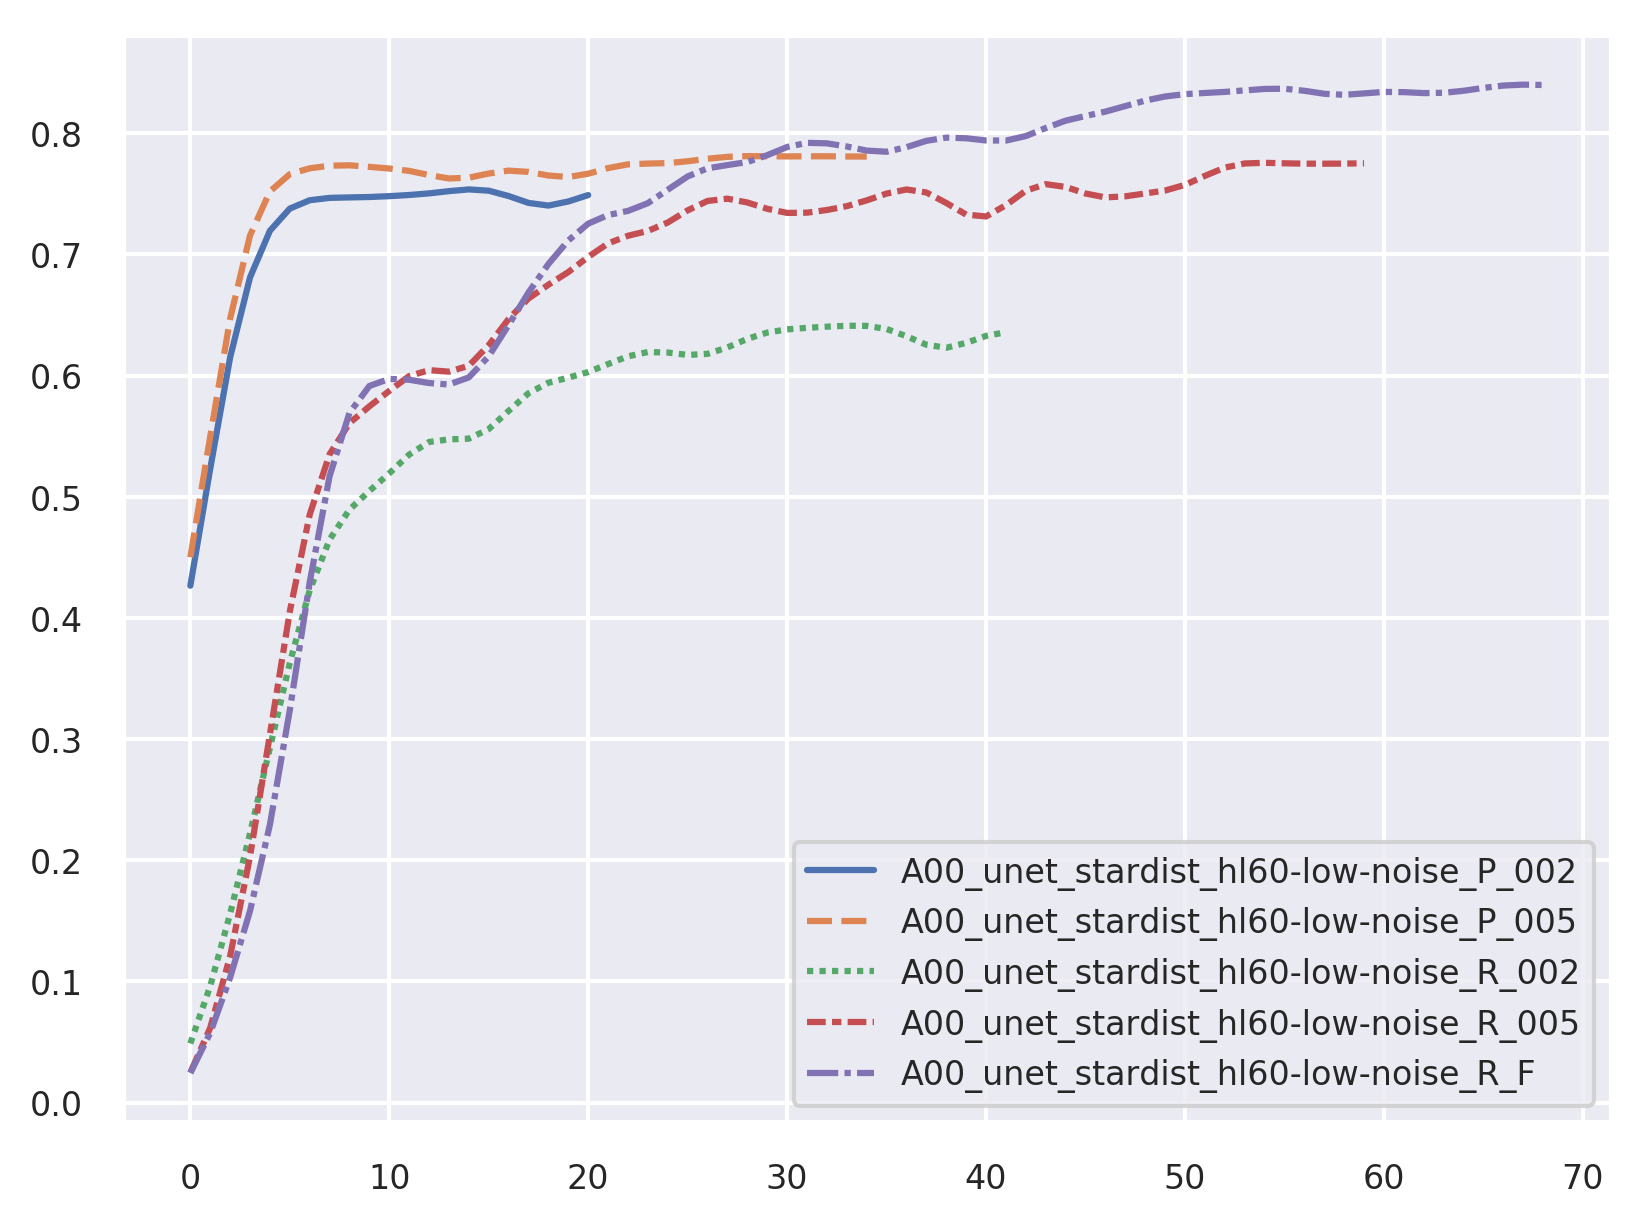

In [2]:
fig = visualize.plot_over_epoch('A00_.*_hl60-low-noise.*_(002|005|F)', 'ap_dsb2018#mean')
# fig.savefig('/tmp/test.pdf')

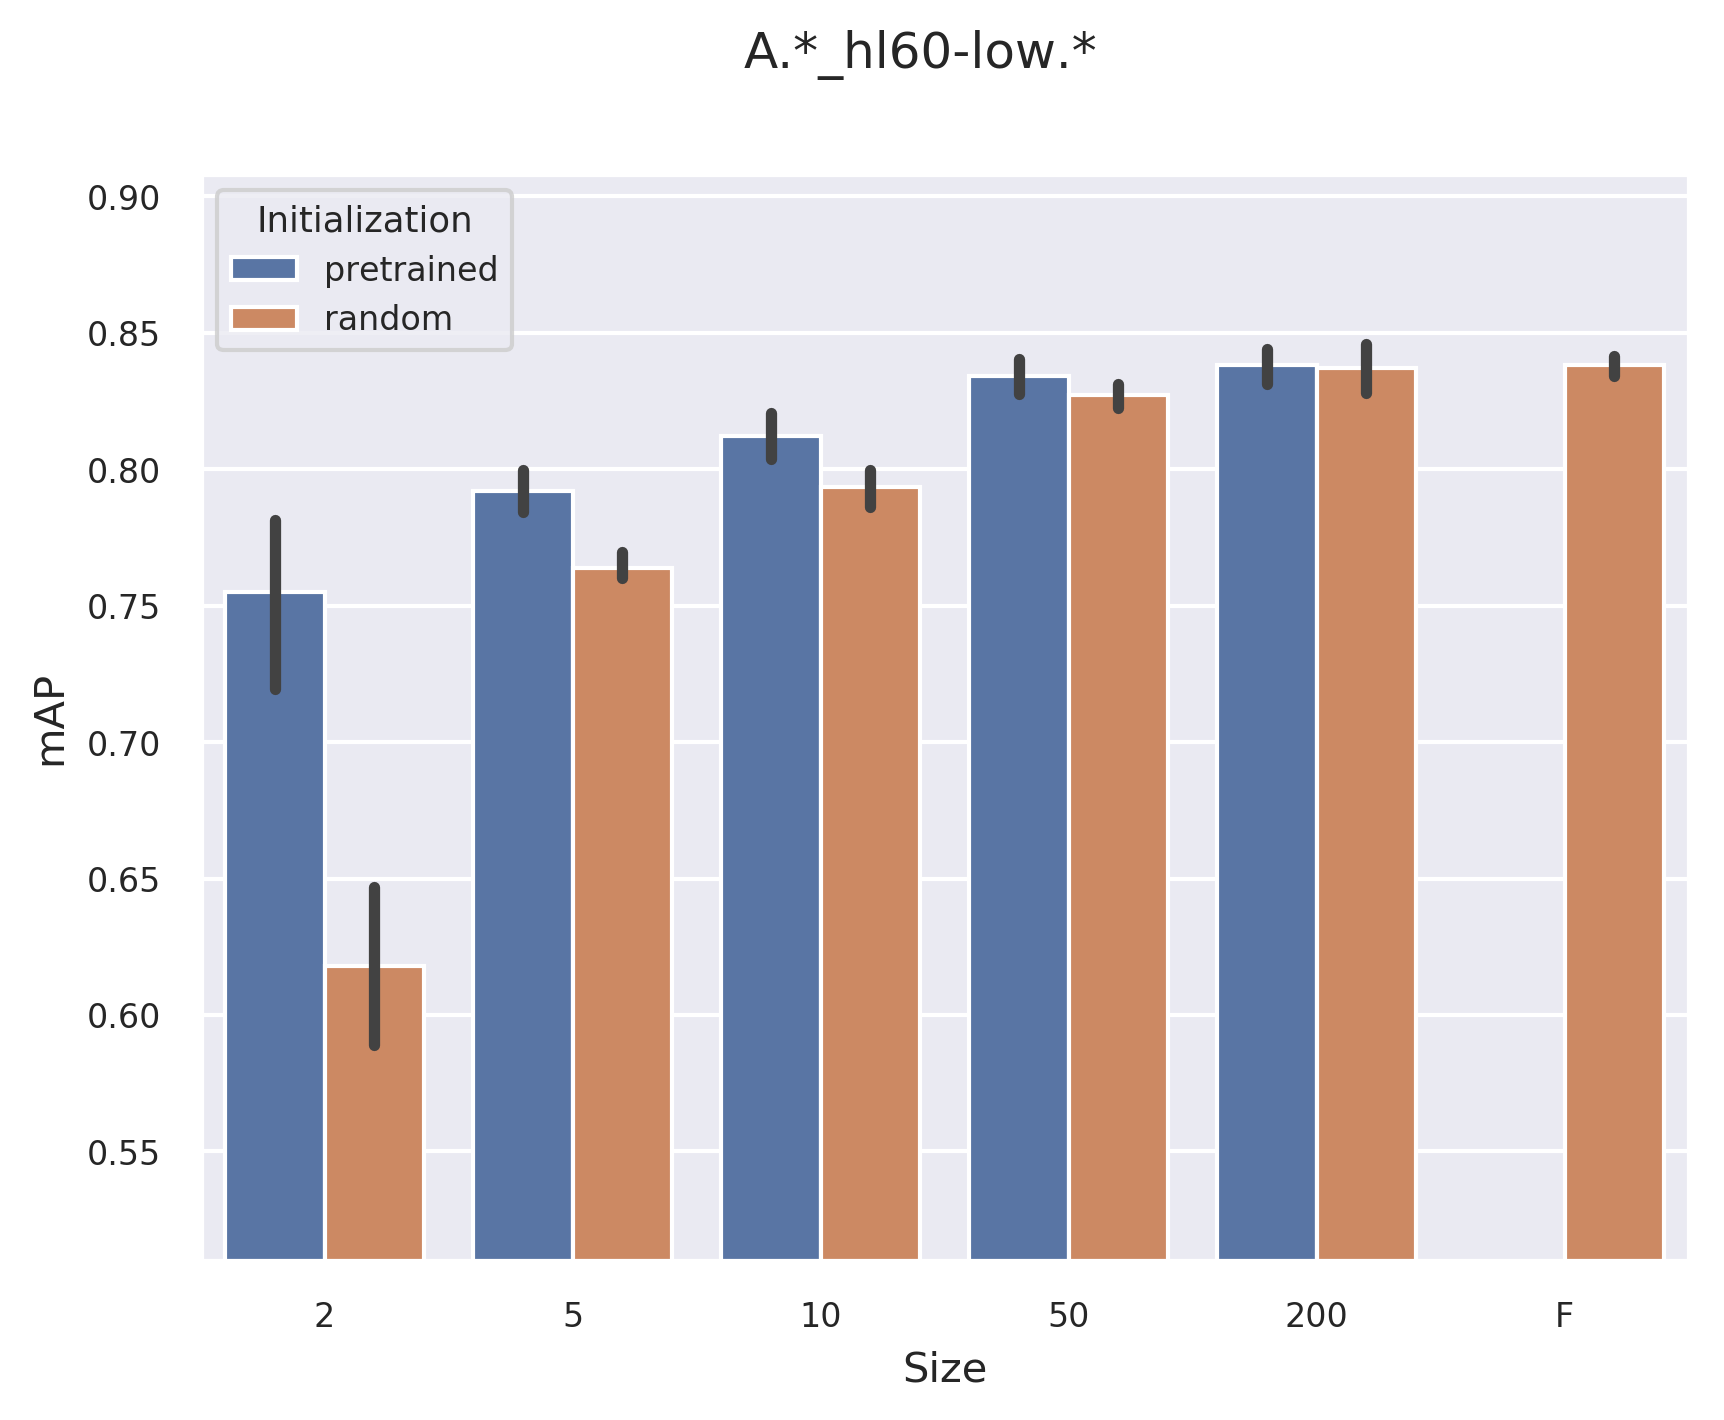

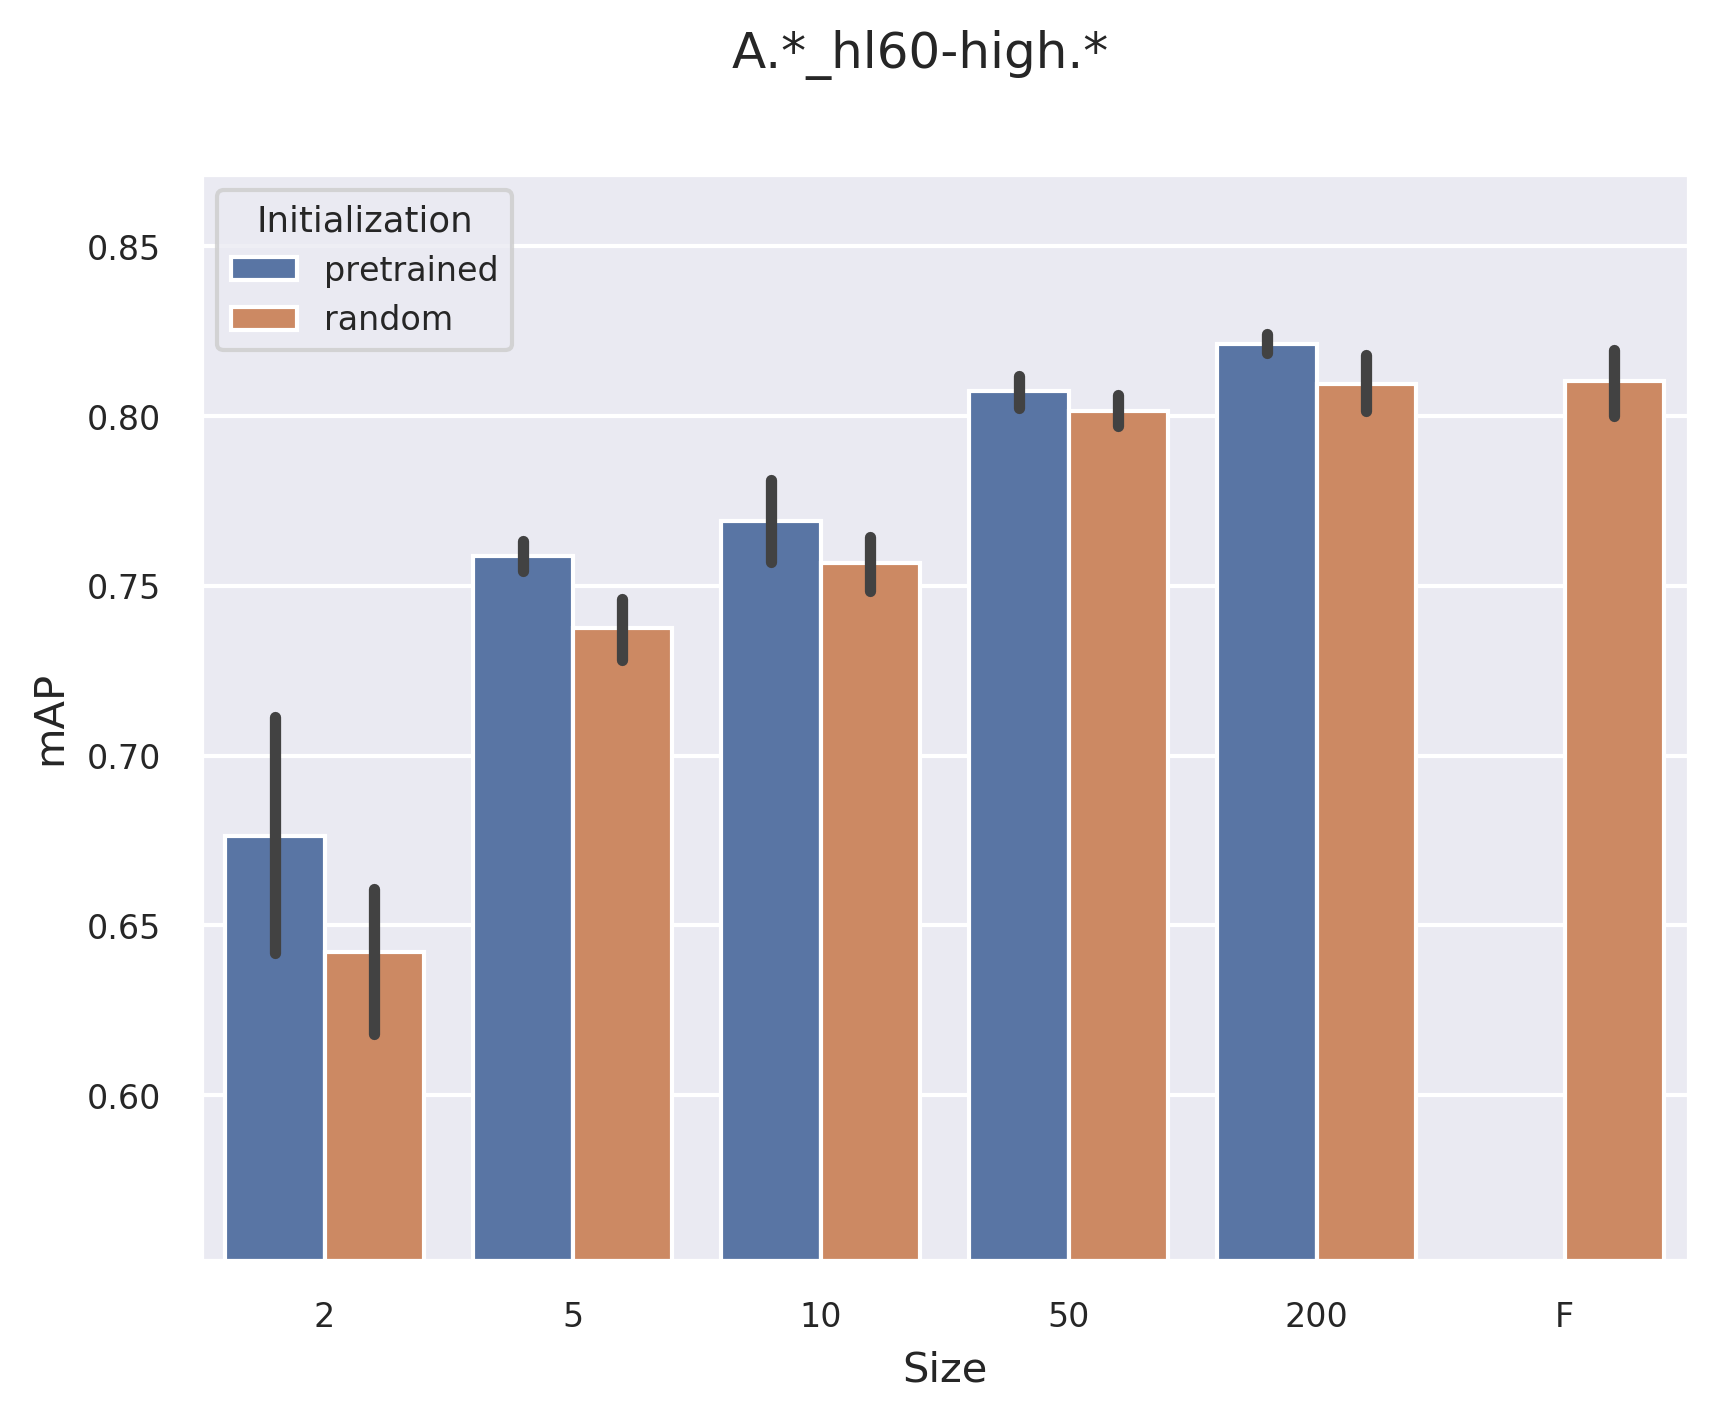

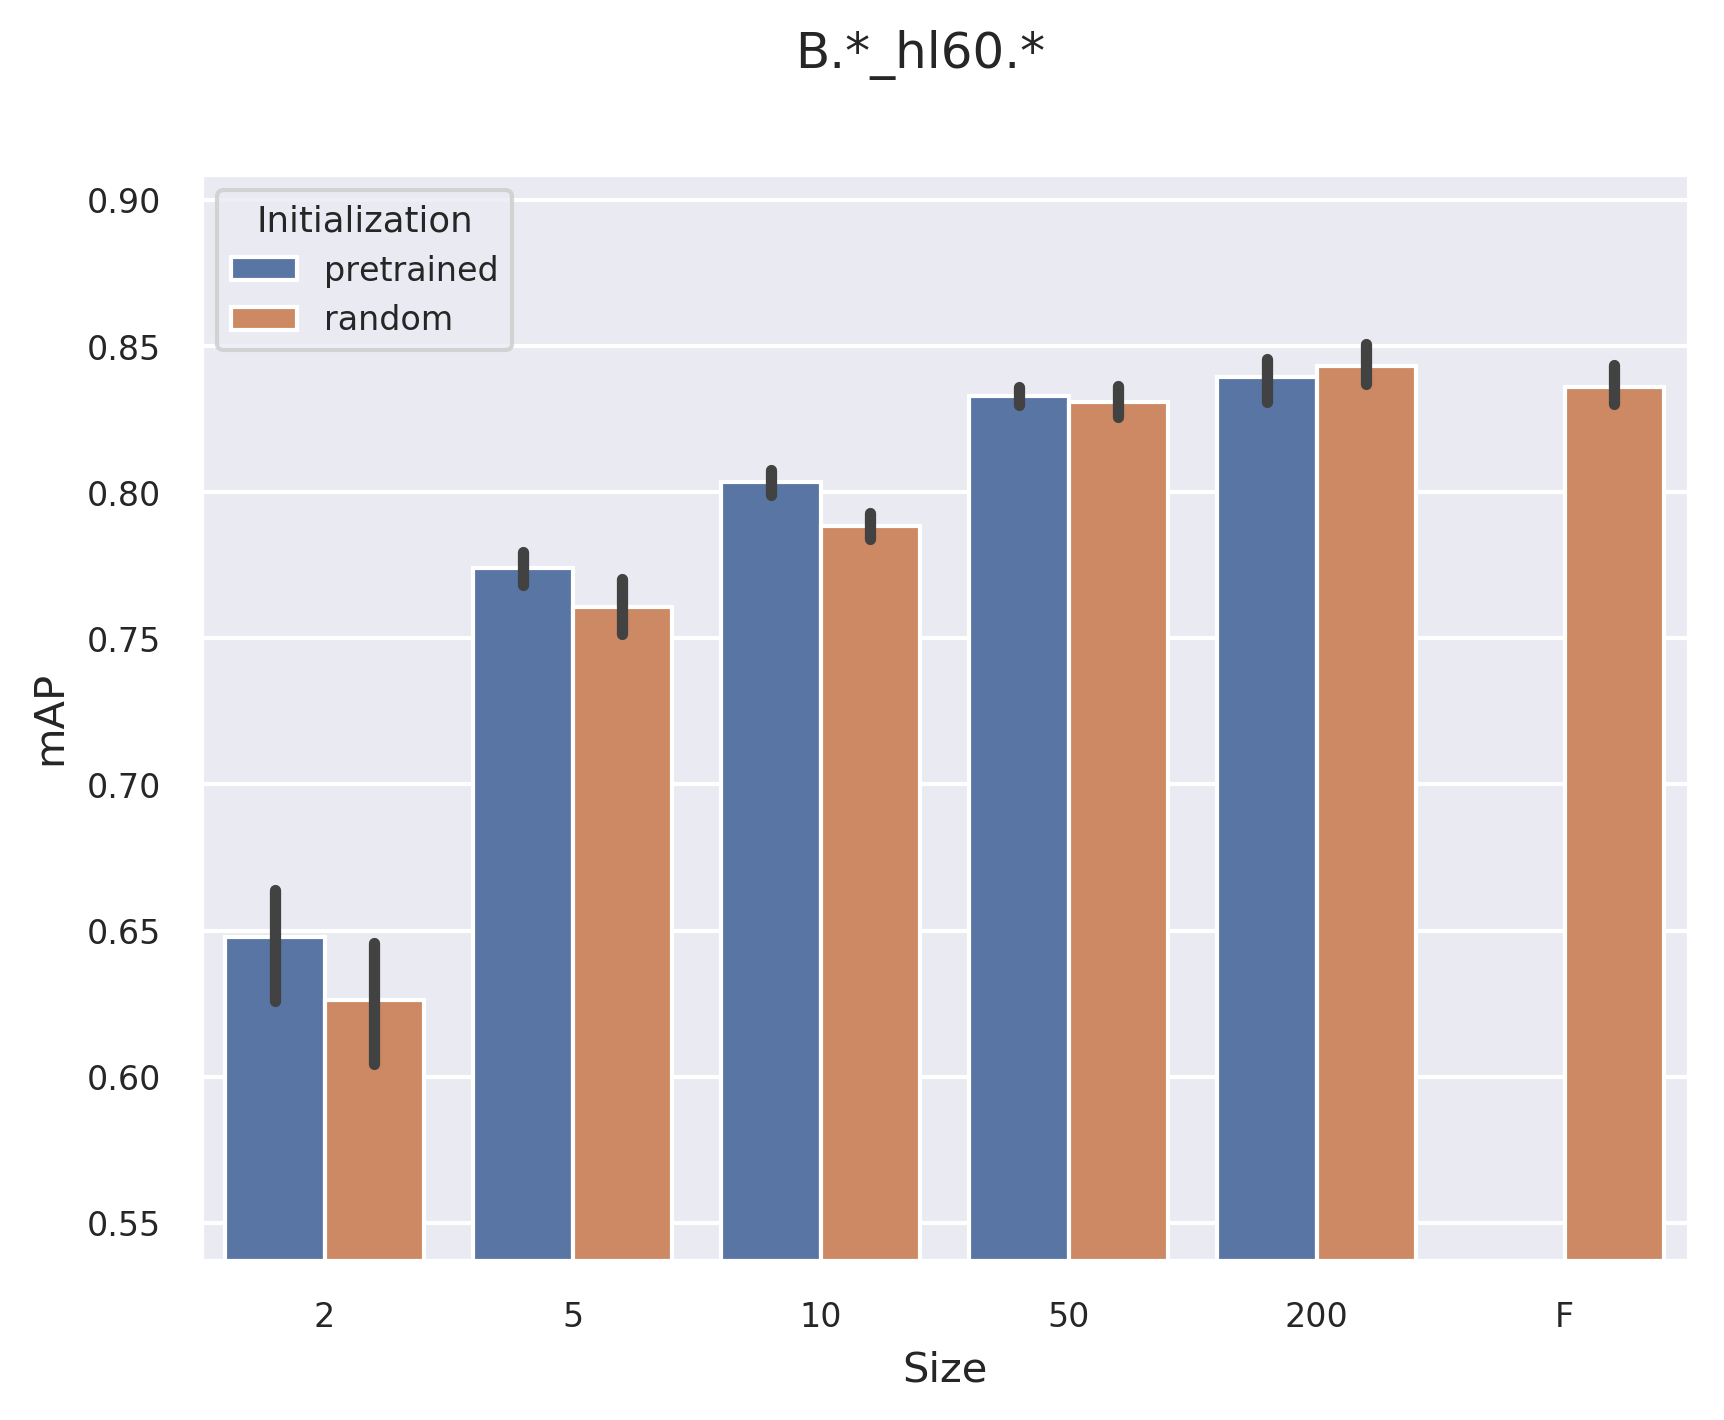

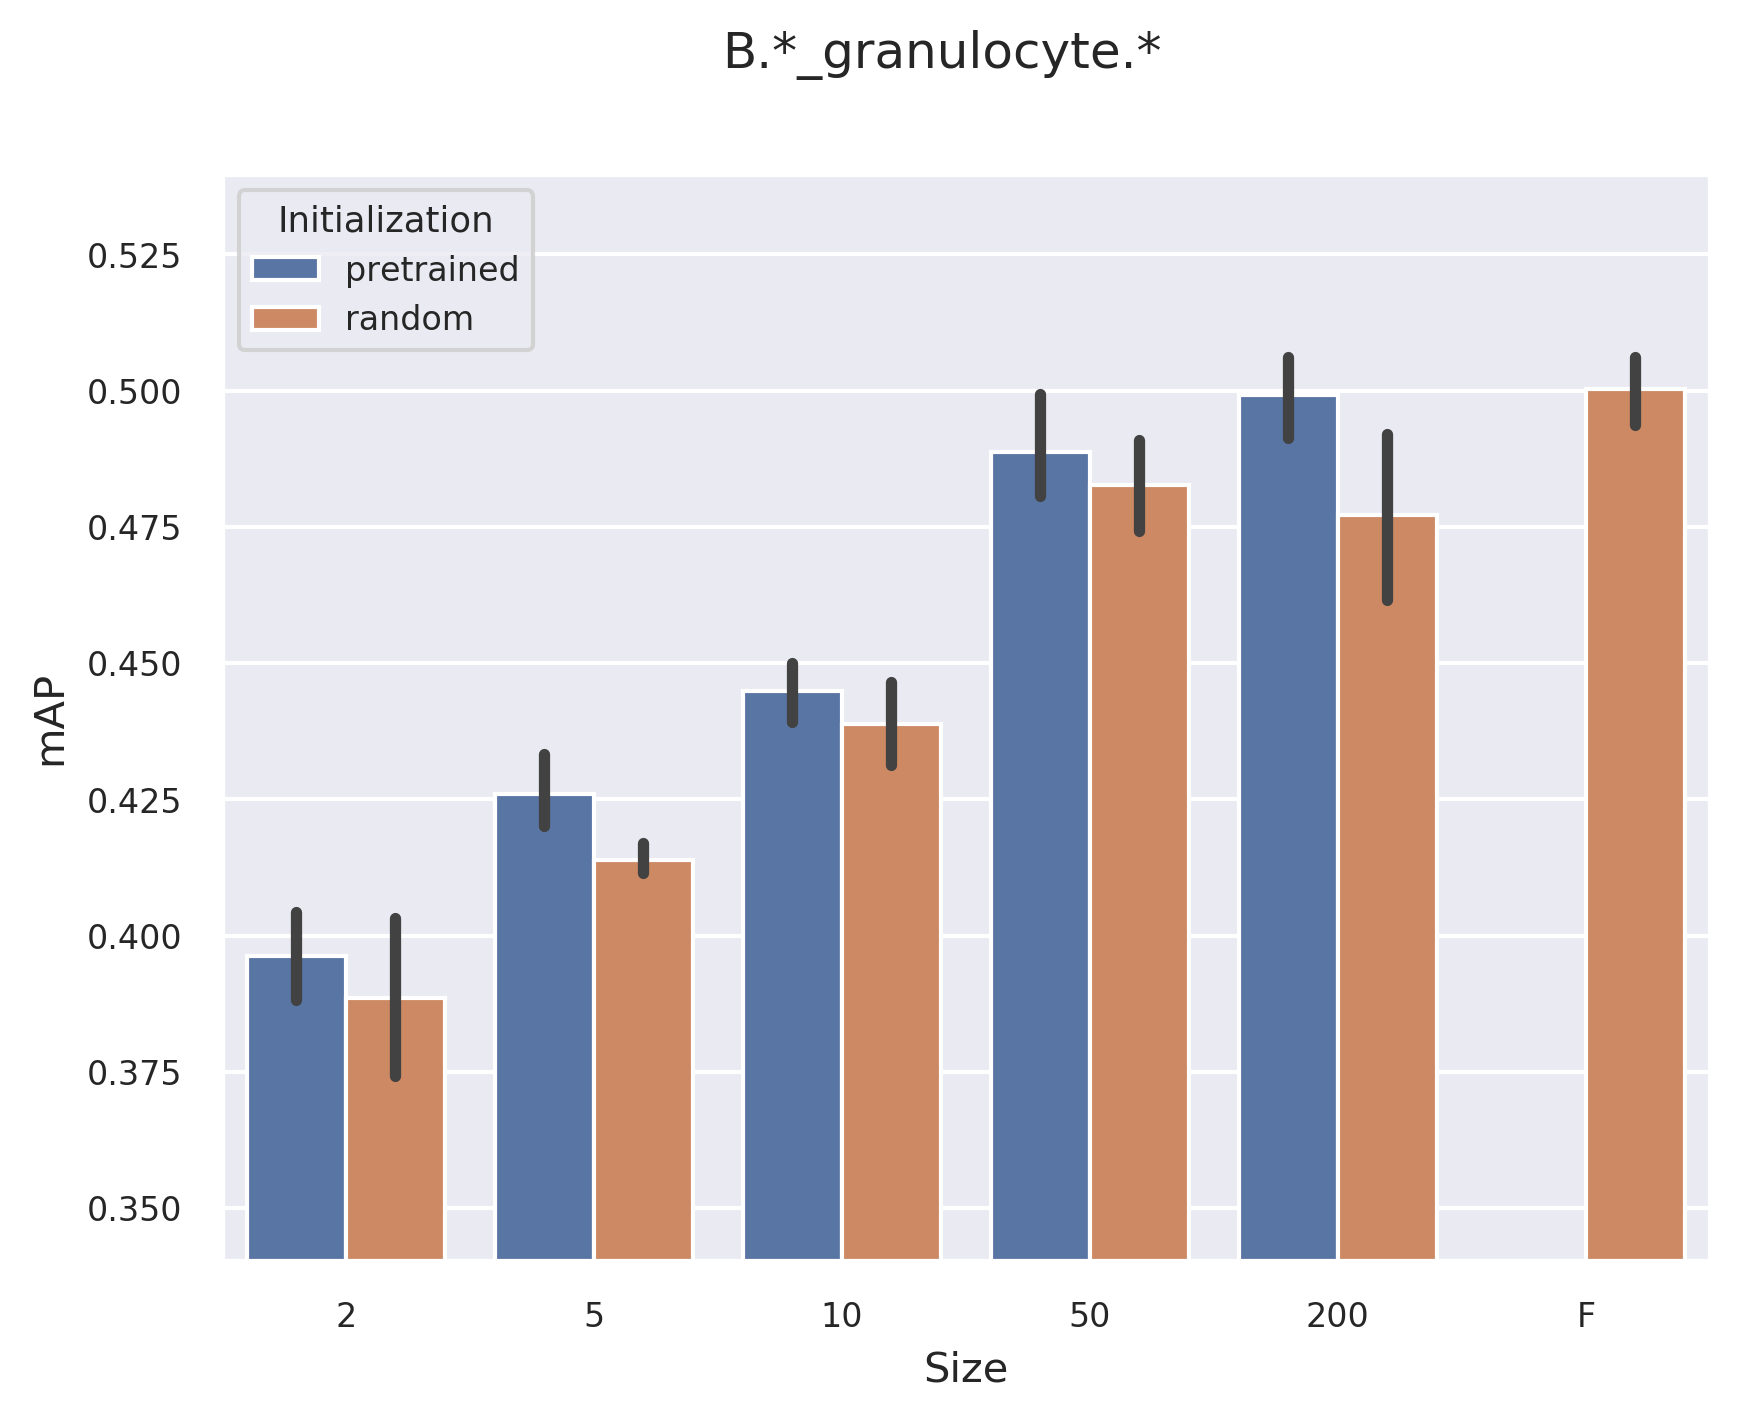

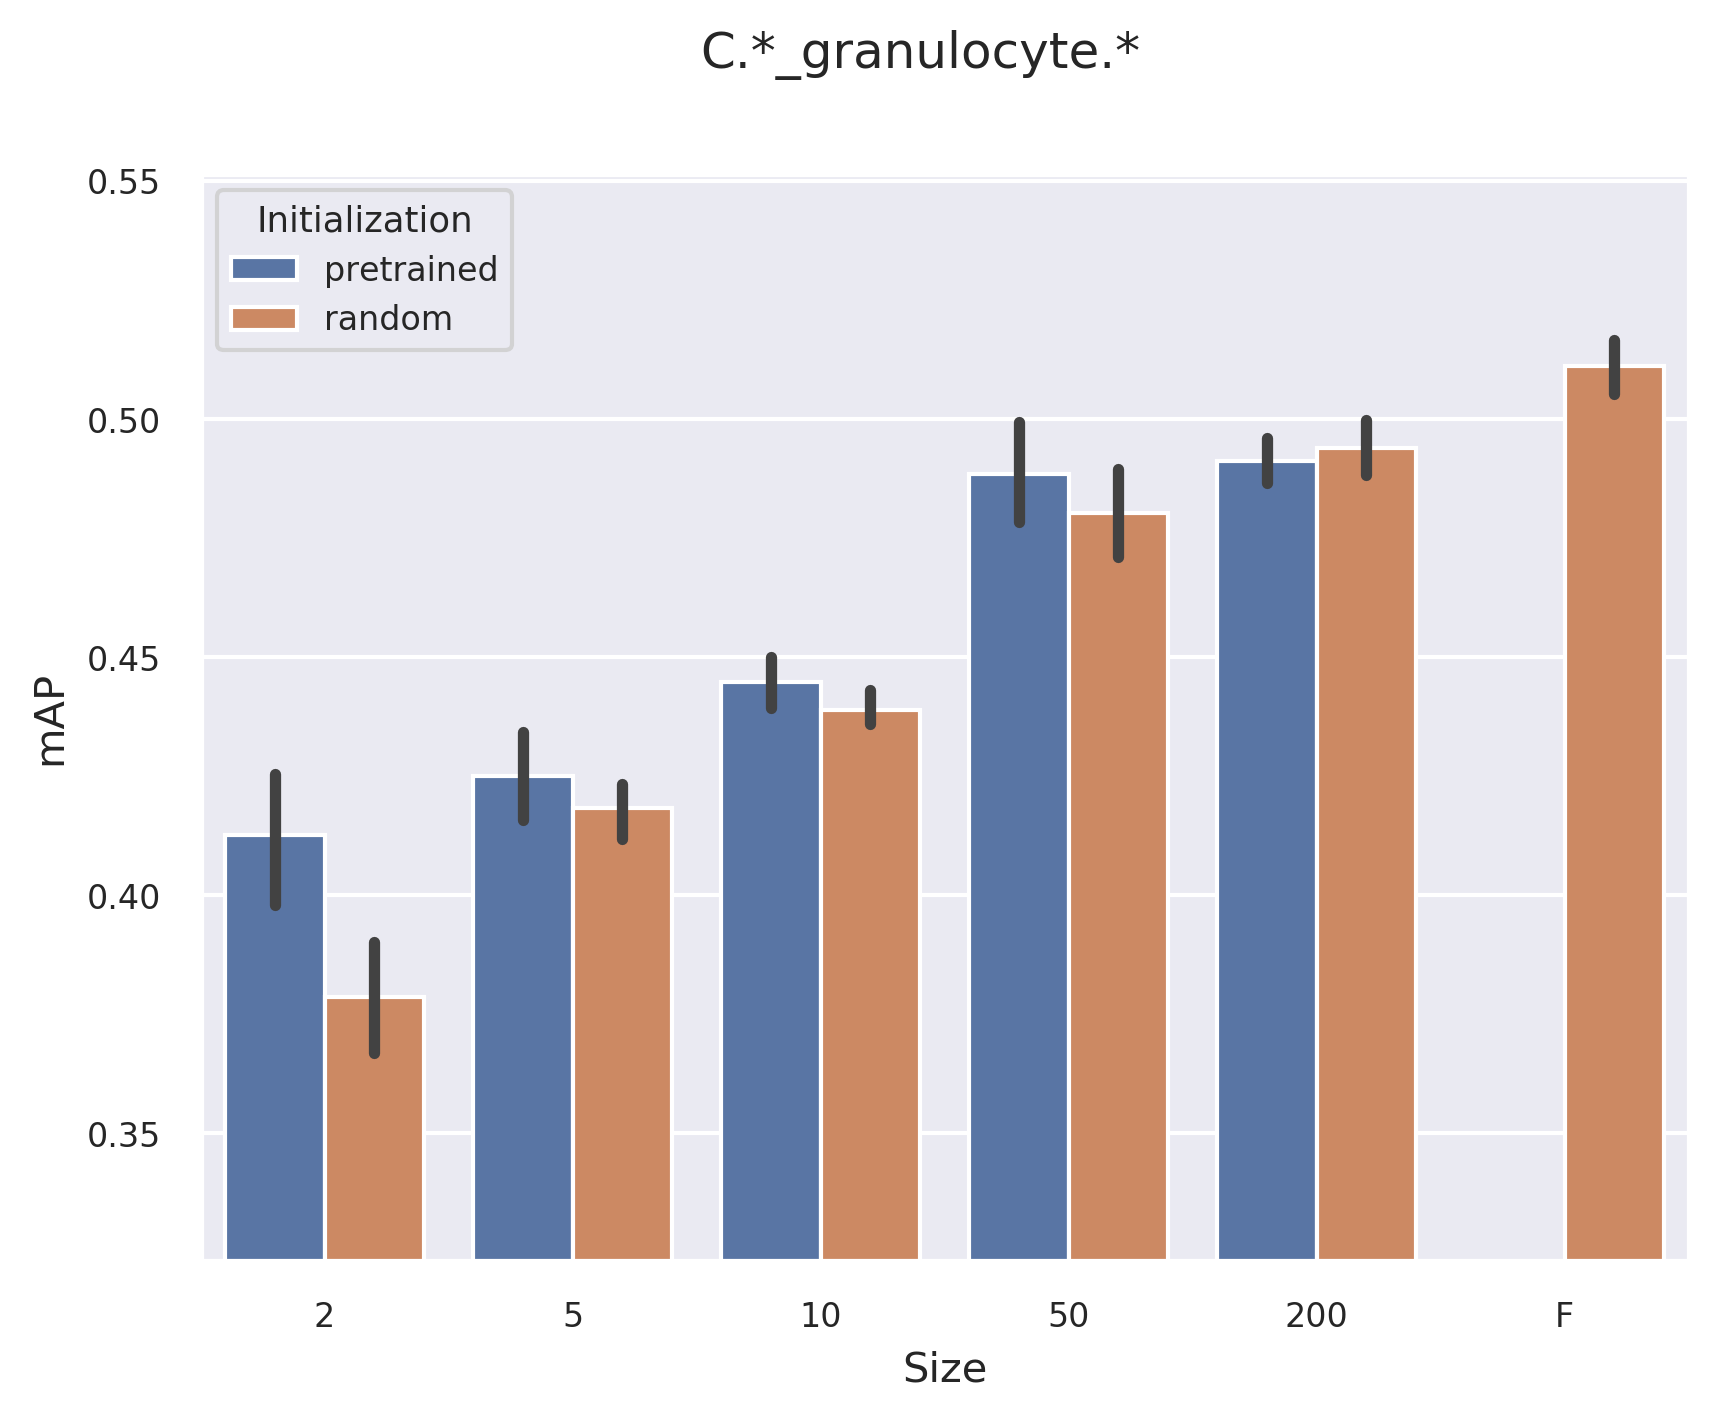

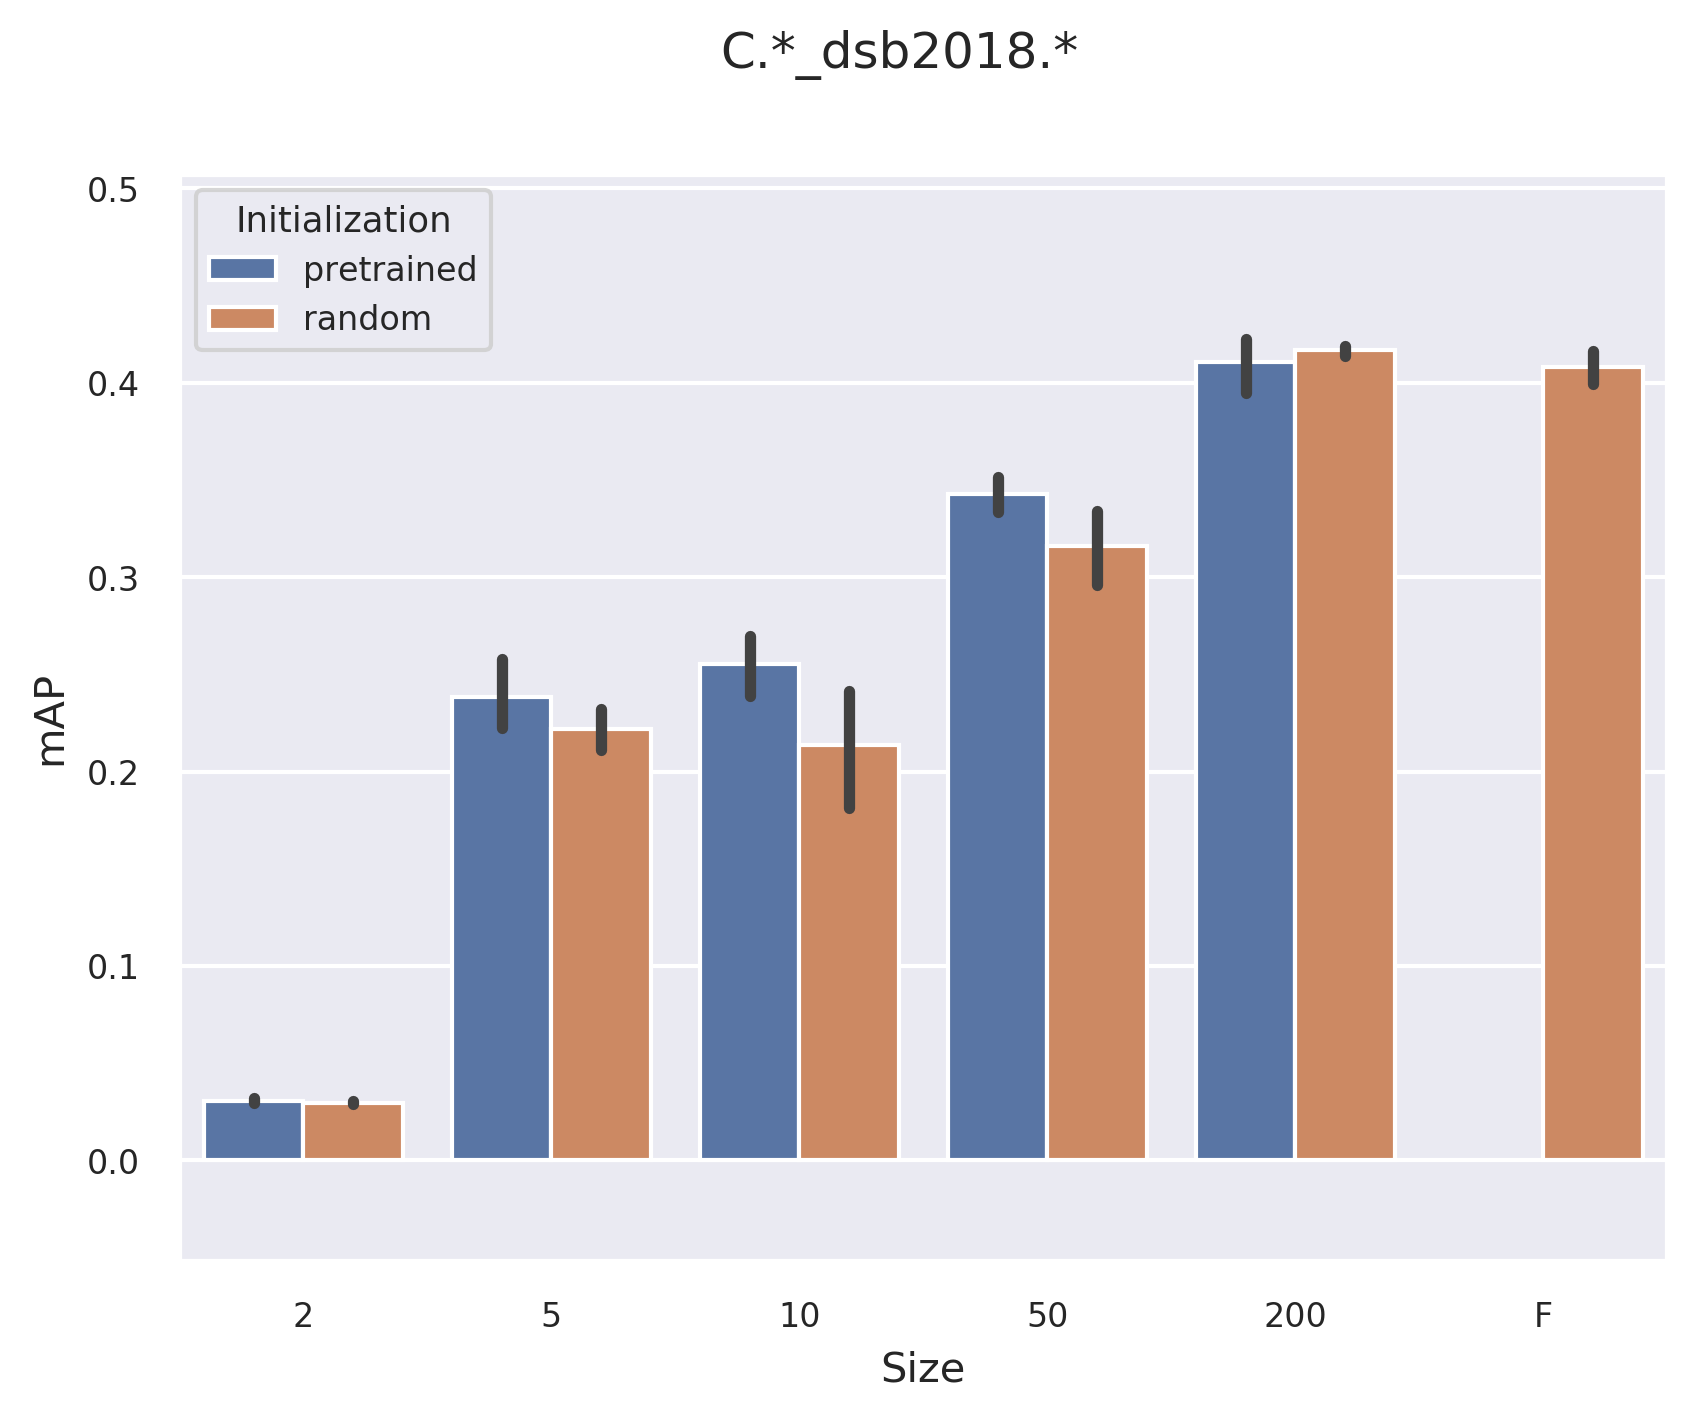

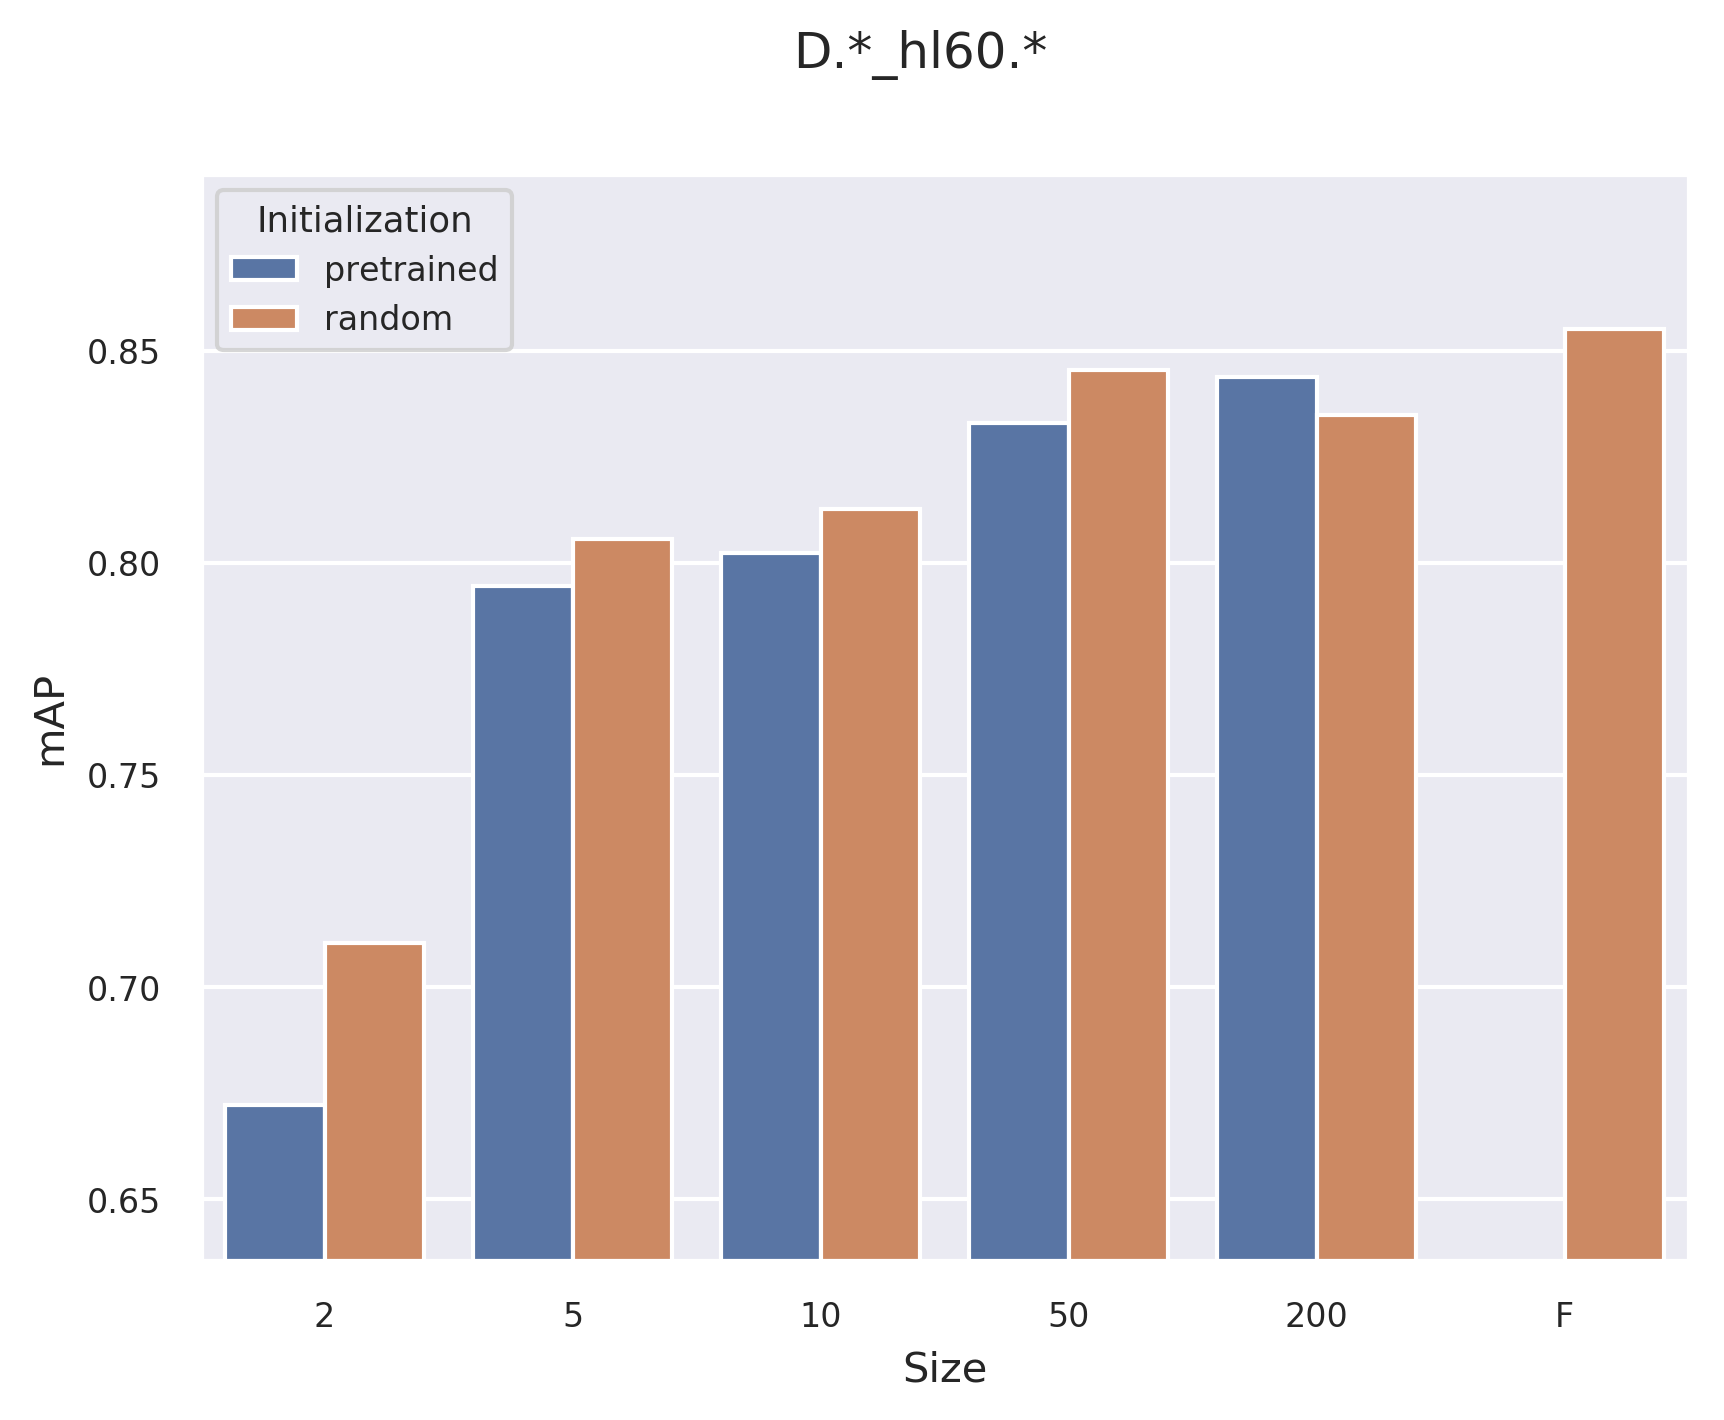

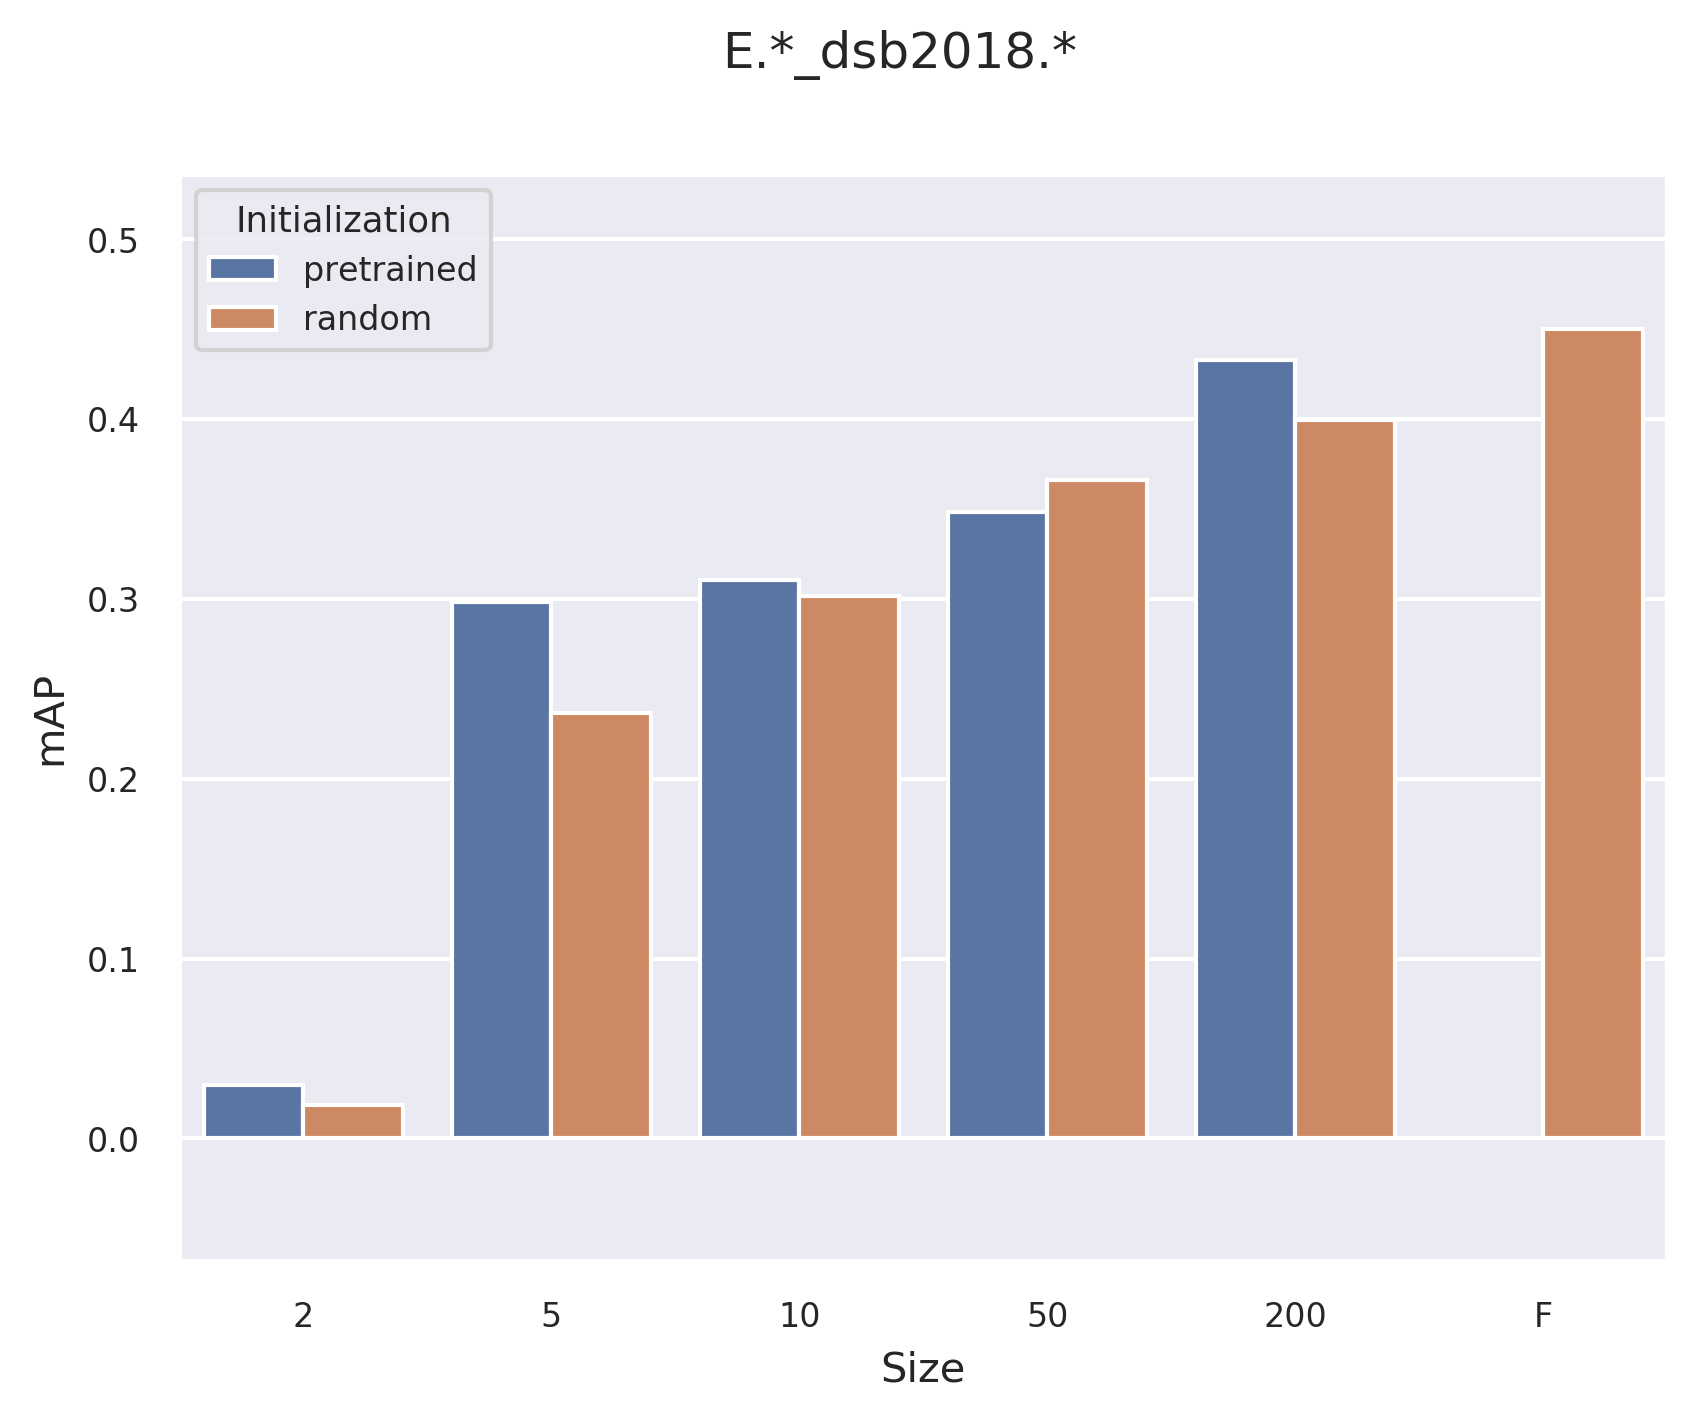

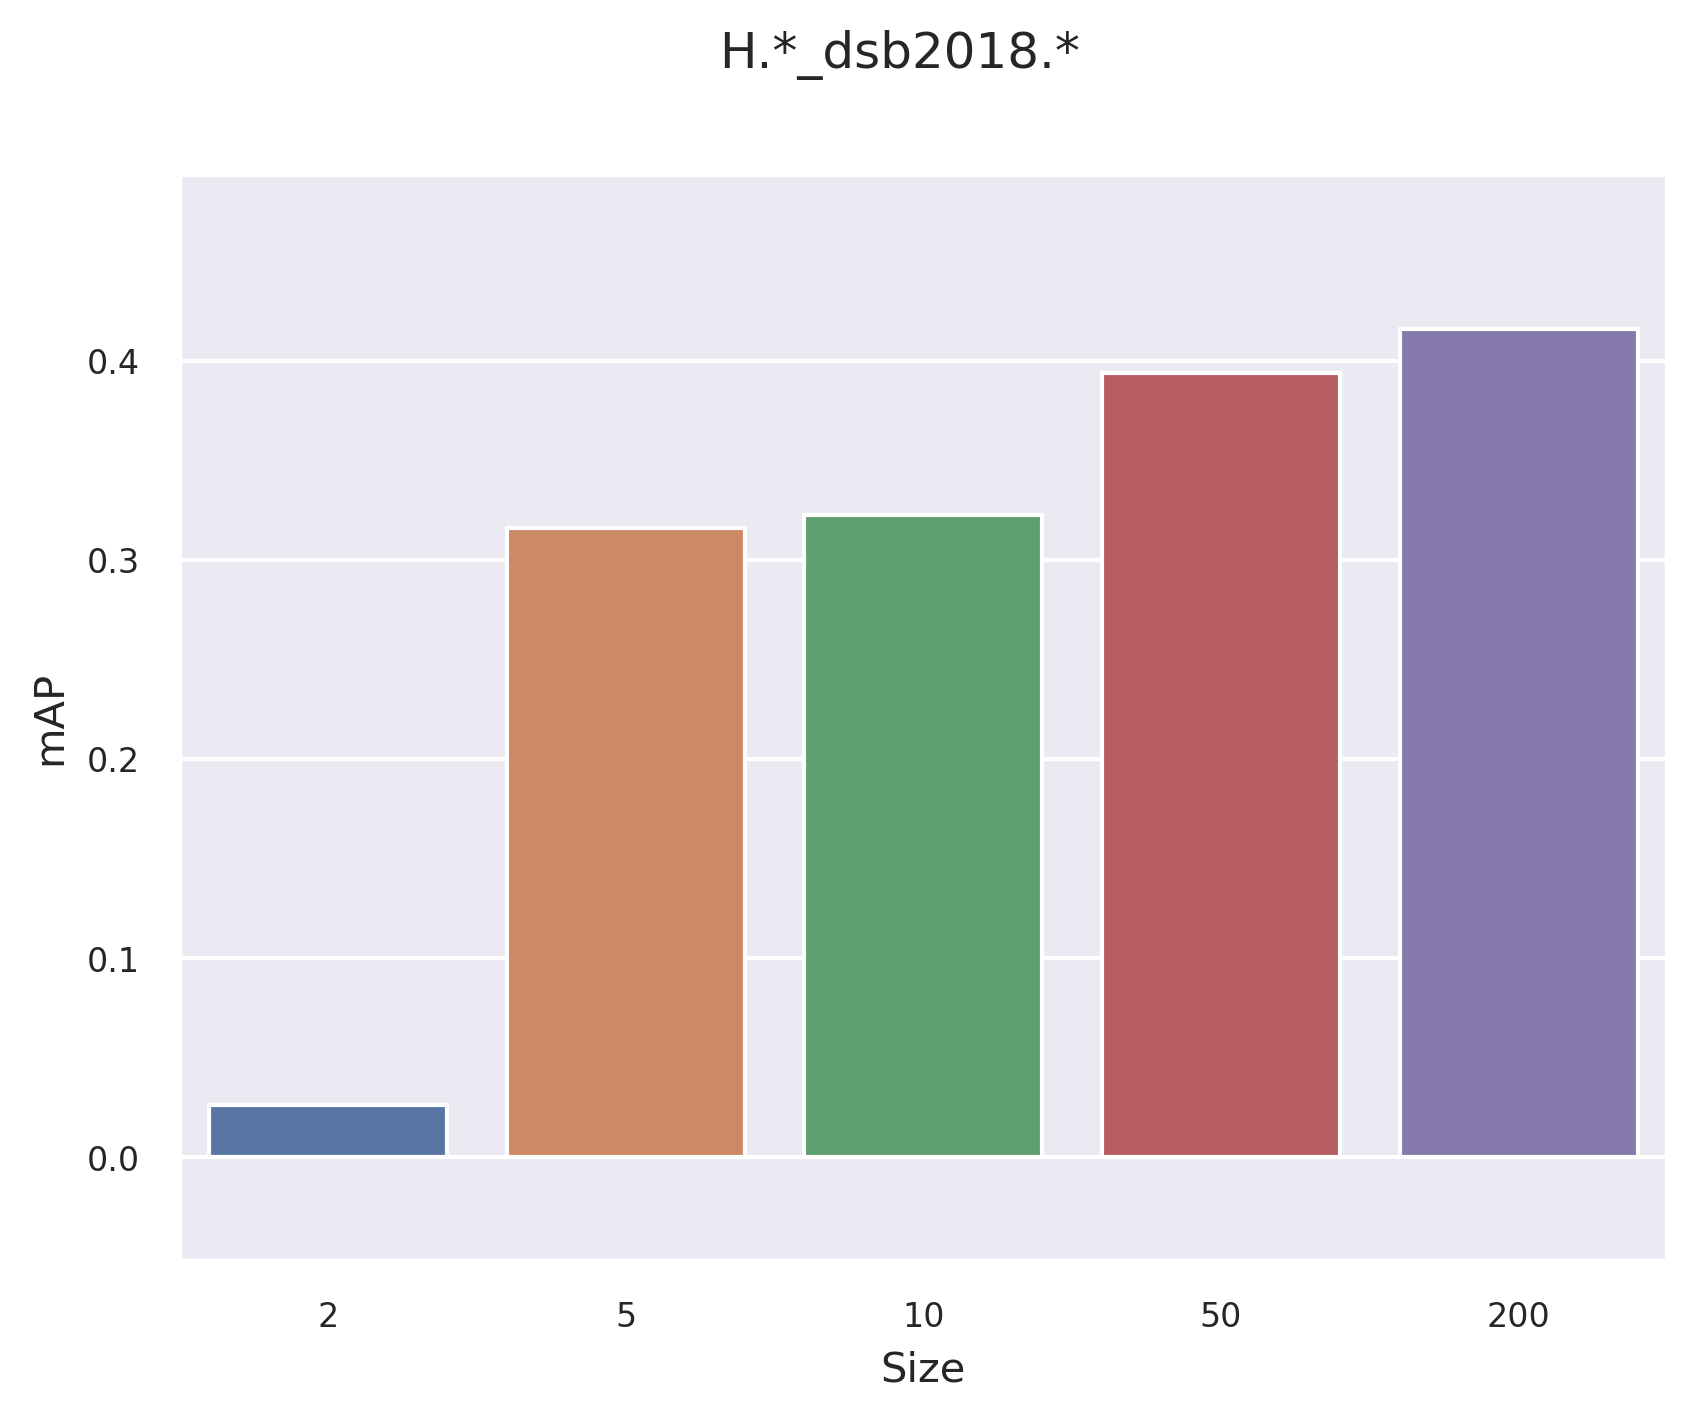

In [3]:
exps = [
    'A.*_hl60-low.*',
    'A.*_hl60-high.*',
    'B.*_hl60.*',
    'B.*_granulocyte.*',
    'C.*_granulocyte.*',
    'C.*_dsb2018.*',
    'D.*_hl60.*',
    'E.*_dsb2018.*',
    'H.*_dsb2018.*'
]
for exp in exps:
    fig = visualize.plot_last(exp, 'ap_dsb2018#mean', ignore_experiment=True)
    fig.suptitle(exp)

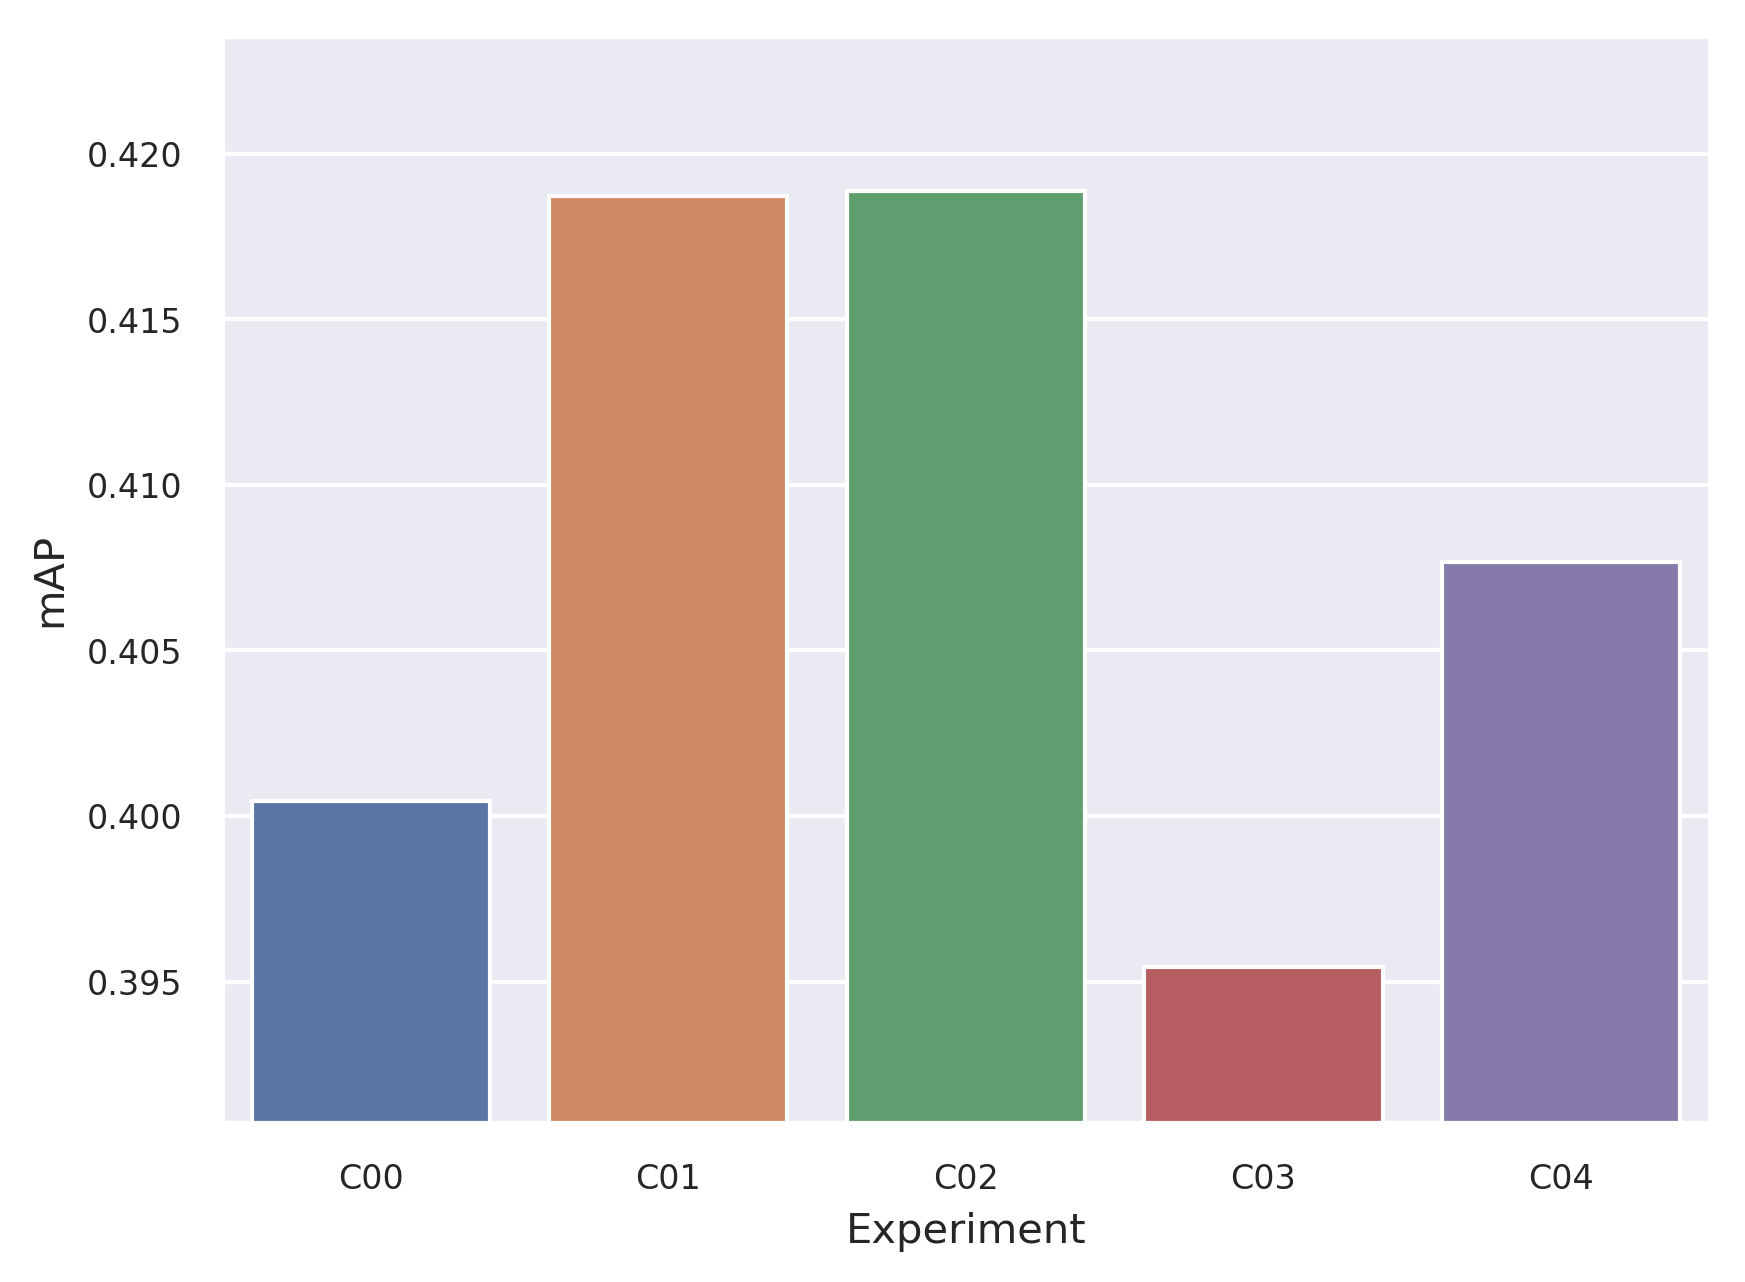

In [4]:
fig = visualize.plot_last('C[0-9][0-9]_.*_dsb2018_R_F', 'ap_dsb2018#mean')

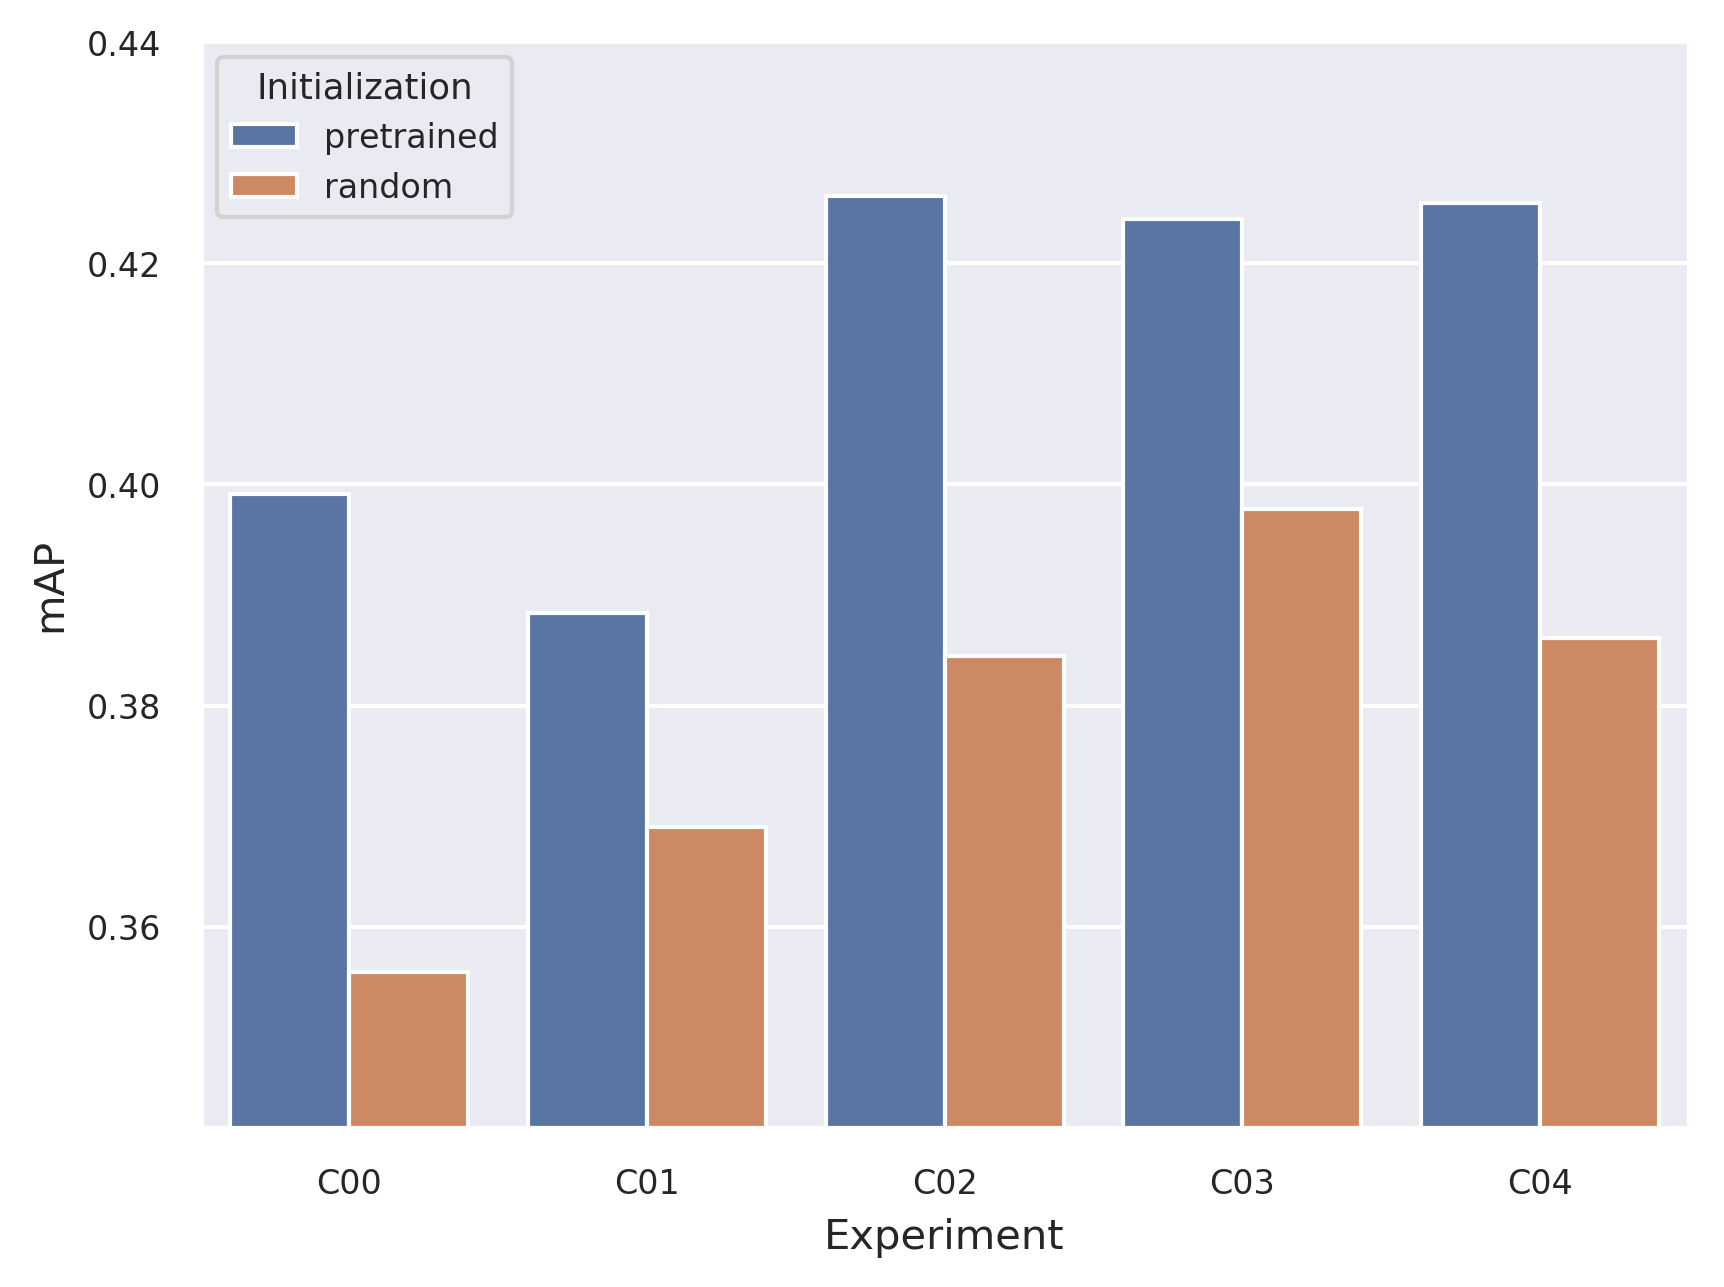

In [5]:
fig = visualize.plot_last('C[0-9][0-9]_.*_granulocyte.*_002', 'ap_dsb2018#mean')